In [1]:
import os
from pymatgen.core.structure import Structure
import pandas as pd
from tqdm import tqdm
import numpy as np
import json

In [2]:
# get a list of all structure file name
cif_dir = os.getcwd() + "/data/27Al_cif_files/"
cif_list = sorted(os.listdir(cif_dir), key=lambda x: int(x.split("_")[0]))

# get structure from the files
struc_dict = {}
for filename in cif_list:
    struc_dict[filename.split(".")[0]] = {
        "name":filename.split(".")[0],
        "structure":Structure.from_file("./data/27Al_cif_files/"+filename),
        }

# open the csv file that contains nmr infos
with open("./data/Al Database_033021.csv", "r") as file:
    nmr_data = pd.read_csv(file)
nmr_data = nmr_data[nmr_data["Structure Name"].notna()]
nmr_data = nmr_data.set_index("Structure Name")

/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/io/cif.py:1165: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [3]:
#Generate structure_tensors object 
for k in tqdm(struc_dict):
    struc_name = k.split("_")[1]
    nmr_dict = nmr_data.loc[struc_name,["site_index","diso (ppm)","etaQ","CQ (MHz)"]]
    #make sure index is int
    if isinstance(nmr_dict['site_index'],pd.core.series.Series):
        nmr_dict['site_index']=list(map(int,nmr_dict["site_index"]))
        nmr_dict = nmr_dict.to_dict("records")
    elif isinstance(nmr_dict['site_index'],np.float64):
        nmr_dict['site_index']=int(nmr_dict["site_index"])
        nmr_dict = [nmr_dict.to_dict()]
    else:
        raise("site index shoud be a number or a series.")
    #Add site coordinations, species and strip the units out of "diso (ppm)" and "CQ (MHz)"
    for nmr in nmr_dict:
        nmr['site_coord'] = list(struc_dict[k]['structure'][nmr["site_index"]].coords)
        nmr["species"] = struc_dict[k]['structure'][nmr["site_index"]].specie.symbol
        nmr['diso'] = nmr["diso (ppm)"]
        nmr['CQ']=abs(nmr["CQ (MHz)"])
        del nmr["diso (ppm)"]
        del nmr["CQ (MHz)"]
    
    struc_dict[k]['tensors'] = nmr_dict
structure_tensors = list(struc_dict.values())

100%|██████████| 70/70 [00:00<00:00, 711.63it/s]


In [4]:
from src.structure_tensors_modifier import get_n_coord_tensors, append_coord_num, add_oxi_state_by_guess
# Add oxidation state for each structures in structure_tensors obj. Might take a long time based on the structure.
structure_tensors = add_oxi_state_by_guess(structure_tensors)
# Filter structure based on coordination number and append coord num info to "tensors".
structure_tensors_filtered = get_n_coord_tensors(structure_tensors, coord=[4, 5, 6])
structure_tensors_filtered = append_coord_num(structure_tensors_filtered)
len(structure_tensors_filtered)

Add oxidation state by guess.


100%|██████████| 70/70 [00:00<00:00, 579.74it/s]


Filter structures based coordination number.


 20%|██        | 14/70 [00:09<00:28,  1.97it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3938: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
100%|██████████| 70/70 [00:23<00:00,  2.94it/s]


num of structures with [4, 5, 6] coords only: 70
Append coordination numbers to tensor list.


100%|██████████| 70/70 [00:23<00:00,  2.95it/s]


70

In [41]:
# Add chemical environment info to "Tensor" list. Might take a long time based on the structure. 
from src.structure_tensors_modifier import append_ce
structure_tensors_filtered = append_ce(structure_tensors_filtered)

Append ChemEnv info to tensor list.

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|██████████| 70/70 [00:22<00:00,  3.07it/s]


In [42]:
# Filter structures based on local chemenv. Here we select T:4 T:5 O:6 sites
from src.structure_tensors_modifier import filter_ce
chemenv_filter = filter_ce(structure_tensors_filtered)

Filter structure_tensors based on ChemEnv info.


100%|██████████| 70/70 [00:00<00:00, 251155.93it/s]

num of structures with chemenv ['T:4', 'T:5', 'O:6'] only: 70


In [43]:
from src.local_features import NMR_local
def zip_nmr_structure_exp(struc_tensor):
    """
    Combine the NMR values and structural parameters into one table.
    """
    table = pd.DataFrame()
    for sample in tqdm(struc_tensor):
        
        NMR_struc = NMR_local(sample["structure"])
        first_bond_length = pd.DataFrame.from_dict(
            NMR_struc.get_first_bond_length(), orient="index"
        )
        first_bond_angle = pd.DataFrame.from_dict(
            NMR_struc.get_first_bond_angle(), orient="index"
        )
        di = pd.DataFrame.from_dict(
            NMR_struc.get_DI(), orient="index", columns=["DI"]
        )
        alchemical_features = pd.DataFrame.from_dict(
            NMR_struc.get_species_features(),orient="index"
        )

        feature_dict = {}
        feature_list = []
        for tensor in sample['tensors']:
            site_index = tensor['site_index']
            feature_dict['CQ'] = tensor['CQ']
            feature_dict["fbl_average"] = first_bond_length.loc[site_index,'fbl_average']
            feature_dict["fbl_std"] = first_bond_length.loc[site_index,"fbl_std"]
            feature_dict["fbl_max"] = first_bond_length.loc[site_index,"fbl_max"]
            feature_dict["fbl_min"] = first_bond_length.loc[site_index,"fbl_min"]
            feature_dict["fba_average"] = first_bond_angle.loc[site_index,"fba_average"]
            feature_dict["fba_std"] = first_bond_angle.loc[site_index,"fba_std"]
            feature_dict["fba_max"] = first_bond_angle.loc[site_index,"fba_max"]
            feature_dict["fba_min"] = first_bond_angle.loc[site_index,"fba_min"]
            feature_dict["DI"] = di.loc[site_index,"DI"]
            alchemical_features_dict = alchemical_features.to_dict('index')[site_index]
            feature_dict = {**feature_dict, **alchemical_features_dict}
            feature_list.append(feature_dict)
            feature_dict = {}
        sample_table = pd.DataFrame(feature_list)

        if table.empty:
            table = sample_table
        else:
            table = table.append(sample_table)  
    return table

In [44]:
nmr_struc_data = zip_nmr_structure_exp(chemenv_filter["filtered"])
nmr_struc_data

  0%|          | 0/70 [00:00<?, ?it/s]/mnt/c/Users/wusha/Documents/GitHub/27Al_CQ_prediction/src/local_features.py:626: RuntimeWarning: divide by zero encountered in reciprocal
  dis_matrix_rev = np.reciprocal(distance_matrix(coords_all,coords_all))
100%|██████████| 70/70 [00:21<00:00,  3.28it/s]


,CQ,fbl_average,fbl_std,fbl_max,fbl_min,fba_average,fba_std,fba_max,fba_min,DI,...,110,111,112,113,114,115,116,117,118,119
0,4.088,1.744693,0.004266,1.748387,1.740998,109.481443,2.007292,111.724217,107.123865,0.014297,...,7.805964e+06,6005.258573,5364.574245,5268.744595,5205.782703,404.452478,122.279134,120.094810,118.666667,12.142030
1,4.090,1.744693,0.004266,1.748387,1.740998,109.481443,2.007292,111.724217,107.123865,0.014297,...,7.805964e+06,6005.258573,5364.574245,5268.744595,5205.782703,404.452478,122.279134,120.094810,118.666667,12.142030
0,8.800,1.859881,0.074738,1.931446,1.752675,106.875474,27.178705,169.448717,78.624325,0.066604,...,7.807082e+06,7824.380424,6306.588063,5545.070981,5192.929416,467.544628,143.754833,127.806263,118.534450,92.086654
0,7.200,1.869081,0.074372,1.951832,1.799928,107.155747,27.548127,170.881090,85.410791,0.056383,...,7.806964e+06,7809.693344,6068.584703,5769.330051,5265.226579,465.375383,138.330373,131.515642,120.460560,93.905463
0,0.425,2.343800,0.000400,2.344228,2.343335,106.595106,34.285646,172.536362,84.151225,0.033680,...,7.858320e+06,75379.952401,45381.072128,45380.021869,44471.207459,424.116758,133.475235,133.472146,130.799133,102.026050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,4.200,1.771588,0.025888,1.792282,1.733786,109.405460,3.233832,114.997520,105.925041,0.020690,...,7.805647e+06,6233.718445,5381.005384,5302.392206,5244.465292,401.143167,122.989776,120.905556,119.973392,12.623227
1,6.300,1.920514,0.031140,1.960073,1.889989,105.633274,32.301670,168.348453,76.860026,0.066844,...,7.808523e+06,9036.390897,6268.070412,6240.999958,5708.459185,529.913853,142.873695,142.305565,130.117612,95.822983
2,NaN,1.771588,0.025888,1.792282,1.733786,109.405460,3.233832,114.997520,105.925041,0.020690,...,7.805647e+06,6233.718445,5381.005384,5302.392206,5244.465292,401.143167,122.989776,120.905556,119.973392,12.623227
3,NaN,1.927027,0.068980,2.014589,1.866315,105.547082,32.109033,167.281997,77.423058,0.069558,...,7.808466e+06,9071.526248,6300.072284,6267.494875,5677.318143,528.922017,143.603838,143.041006,129.407765,95.359104


In [45]:
nmr_struc_data=nmr_struc_data[nmr_struc_data['CQ'].notna()]

In [46]:
# split y and x
y = nmr_struc_data["CQ"]
x = nmr_struc_data.loc[:, "fbl_average":]

In [47]:
import pickle
# load the best fitted model from disk
dir_ = "./models/best/"
filename = 'Best_model_10132021.sav'
grid = pickle.load(open(dir_+filename, 'rb'))

test scores: R2 = 0.8039500169518236, RMSE = 1.729894799496158, MAE = 1.243120765512036


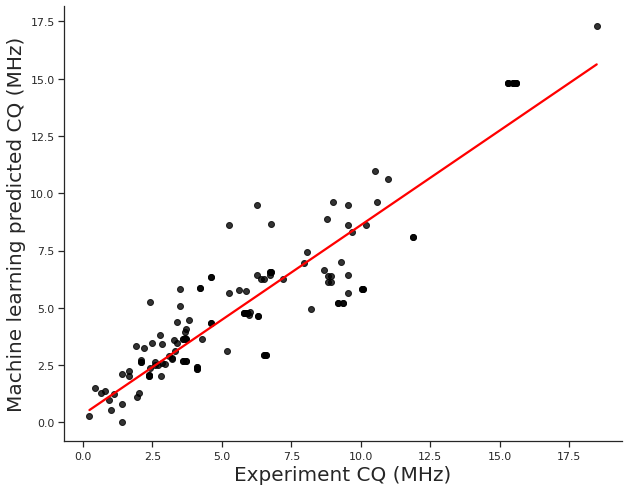

CPU times: user 266 ms, sys: 125 ms, total: 391 ms
Wall time: 174 ms


In [48]:
%%time
# Predict using kernel ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import math

sns.set()
import matplotlib.pyplot as plt
from datetime import datetime


y_rf = grid.predict(x)

test_r2 = r2_score(y, y_rf)
test_RMSE = math.sqrt(mean_squared_error(y, y_rf))
test_MAE = mean_absolute_error(y, y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["Experiment CQ"] = y
predict_result["Machine learning predicted CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

#plotting
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,8))
plot = sns.regplot(
    x="Experiment CQ",
    y='Machine learning predicted CQ',
    data=predict_result,
    ci=None,
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)

ax.set_xlabel("Experiment CQ (MHz)",fontsize=20)
ax.set_ylabel("Machine learning predicted CQ (MHz)",fontsize=20)
sns.despine()

plt.show()